In [9]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose, ZeroPadding2D, Cropping2D
from tensorflow.keras.models import Model
from shutil import copyfile, rmtree
from timeit import default_timer as timer

In [10]:
#ОС - библиотека для работы с операционкой. Этой командой видим путь
INPUT_ROOT = "ML - 2"
def from_input(path):
    return os.path.join(INPUT_ROOT, path)

In [11]:
# Загружаем csv о обучении.
train_info = pd.read_csv(from_input("Train.csv"))
train_info.groupby('ClassId')['ClassId'].count()

ClassId
0      210
1     2220
2     2250
3     1410
4     1980
5     1860
6      420
7     1440
8     1410
9     1470
10    2010
11    1320
12    2100
13    2160
14     780
15     630
16     420
17    1110
18    1200
19     210
20     360
21     330
22     390
23     510
24     270
25    1500
26     600
27     240
28     540
29     270
30     450
31     780
32     240
33     689
34     420
35    1200
36     390
37     210
38    2070
39     300
40     360
41     240
42     240
Name: ClassId, dtype: int64

In [12]:
# Загружаем csv о тесте.
test_info =  pd.read_csv(from_input("Test.csv"))
test_info.groupby('ClassId')['ClassId'].count()

ClassId
0      60
1     720
2     750
3     450
4     660
5     630
6     150
7     450
8     450
9     480
10    660
11    420
12    690
13    720
14    270
15    210
16    150
17    360
18    390
19     60
20     90
21     90
22    120
23    150
24     90
25    480
26    180
27     60
28    150
29     90
30    150
31    270
32     60
33    210
34    120
35    390
36    120
37     60
38    690
39     90
40     90
41     60
42     90
Name: ClassId, dtype: int64

In [13]:
TARGET_SIZE = (40, 40) # изображения будут изменены до этого размера
FLATTEN_SIZE = TARGET_SIZE[0] * TARGET_SIZE[1] * 3
BATCH_SIZE=500

In [14]:
paths = train_info['Path'].values
y_train = train_info['ClassId'].values

indices = np.arange(y_train.shape[0])
randgen = random.Random(62)
randgen.shuffle(indices)

paths = paths[indices]
y_train = y_train[indices]
y_train = to_categorical(y_train, 43)

train_data=[]

for i, f in enumerate(paths):
    print('\rLoading data {0:.1f}%...'.format((i / len(paths)) * 100), end = '\r')
    image = load_img(os.path.join(from_input('train'), f.replace('Train/', '')), target_size=TARGET_SIZE)
    train_data.append(img_to_array(image))

print('Data loaded.              ')

Data loaded.              


In [15]:
X_train = tf.keras.applications.vgg16.preprocess_input(np.array(train_data))
train_data = None

In [16]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow(X_train,
                                    y_train,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    seed=17)

train_aug_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       rotation_range = 18,
                                       width_shift_range = 0.18,
                                       height_shift_range = 0.18,
                                       shear_range = 0.18,
                                       zoom_range = 0.18,
                                       horizontal_flip = False)

train_aug_generator = train_datagen.flow(X_train,
                                    y_train,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    seed=17)

In [17]:
paths = test_info['Path'].values
y_test = test_info['ClassId'].values
y_test = to_categorical(y_test, 43)

test_data=[]

for i, f in enumerate(paths):
    print('\rLoading data {0:.1f}%...'.format((i / len(paths)) * 100), end = '\r')
    image = load_img(os.path.join(from_input('test'), f.replace('Test/', '')), target_size=TARGET_SIZE)
    test_data.append(img_to_array(image))

print('Data loaded.              ')

Data loaded.              


In [18]:
X_test = tf.keras.applications.vgg16.preprocess_input(np.array(test_data))
test_data = None

In [19]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow(X_test,
                                    y_test,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    seed=17)

In [20]:
def plot(history, plot_accuracy = True):
    %matplotlib inline

    import matplotlib.image  as mpimg
    import matplotlib.pyplot as plt

    
    loss=history.history['loss']
    epochs=range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'r', "Training Loss")
    plt.xlabel('Epoch')
    plt.title('Training loss')
    # validation
    plt.plot(epochs, history.history['val_loss'], 'b', "Validation Loss")

    if plot_accuracy:
        accuracy=history.history['accuracy']
        plt.figure()
        plt.plot(epochs, accuracy, 'r', "Training Accuracy")
        plt.title('Training accuracy')
        plt.xlabel('Epoch')
        plt.plot(epochs, history.history['val_accuracy'], 'b', "Validation Accuracy")

In [21]:
def show_layers(model):
    print('Name\tOutput shape\tActivation\tInitializer')
    for l in model.layers:
        print('{0}({1})\t{2}\t{3}\t{4}'
            .format(l.name,
              l.__class__.__name__,
              l.output_shape,
              l.activation.__name__ if hasattr(l, 'activation') else '<none>',
              l.kernel_initializer.__class__.__name__ if hasattr(l, 'kernel_initializer') else '<none>'))


def custom_summary(model):
    model.summary()
    show_layers(model)

In [22]:
VERBOSE=1

In [23]:
def train_model(model, optimizer, epochs, train_generator):
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    start_time = timer()
    history = model.fit_generator(train_generator,
                        epochs=epochs,
                        verbose=VERBOSE,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.0001, patience=2)],
                        validation_data=test_generator,
                        steps_per_epoch= round(X_train.shape[0] / BATCH_SIZE))
    end_time = timer()
    
    print('==============================')
    print('Optimizer: ', optimizer.__class__.__name__)
    print('Learning rate: ', optimizer.get_config()['learning_rate'])
    print('Epochs: ', epochs)
    print('==============================')
    print('Trained in {0:.2f} minutes'.format((end_time - start_time) / 60))
    
    accuracy=history.history['accuracy'][-1]
    test_accuracy = model.evaluate_generator(test_generator)[1]
    
    print('Results at the end of training: accuracy={1:.02f}%, test_accuracy={2:.02f}%'
          .format(i, accuracy*100, test_accuracy*100))

    plot(history)

In [24]:
def get_classificator_model(base_model, last_output):
    x = Flatten()(last_output)
    x = Dropout(0.33)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.33)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(43, activation='softmax')(x)           

    model = Model(base_model.input, x)
    return model

In [25]:
IMG_SHAPE = TARGET_SIZE + (3,)

In [26]:
pretrained_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 40, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 40, 40, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 40, 40, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 20, 20, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 20, 20, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 20, 20, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 10, 10, 128)       0     

In [27]:
for layer in pretrained_model.layers:
    layer.trainable = False

last_layer = pretrained_model.get_layer('block4_conv3')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 5, 5, 512)


Epoch 1/10


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10316\1527297203.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


78/78 [==============================] - 146s 2s/step - loss: 2.1070 - accuracy: 0.4479 - val_loss: 1.1889 - val_accuracy: 0.6274
Epoch 2/10
78/78 [==============================] - 145s 2s/step - loss: 0.9181 - accuracy: 0.7008 - val_loss: 0.9761 - val_accuracy: 0.6861
Epoch 3/10
78/78 [==============================] - 143s 2s/step - loss: 0.6241 - accuracy: 0.7918 - val_loss: 0.9109 - val_accuracy: 0.7140
Epoch 4/10
78/78 [==============================] - 143s 2s/step - loss: 0.4994 - accuracy: 0.8343 - val_loss: 0.8676 - val_accuracy: 0.7320
Epoch 5/10
78/78 [==============================] - 143s 2s/step - loss: 0.4136 - accuracy: 0.8598 - val_loss: 0.8211 - val_accuracy: 0.7581
Epoch 6/10
78/78 [==============================] - 143s 2s/step - loss: 0.3547 - accuracy: 0.8805 - val_loss: 0.8052 - val_accuracy: 0.7618
Epoch 7/10
78/78 [==============================] - 143s 2s/step - loss: 0.3294 - accuracy: 0.8884 - val_loss: 0.8452 - val_accuracy: 0.7551
Epoch 8/10
78/78 [======

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10316\1527297203.py:21: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_accuracy = model.evaluate_generator(test_generator)[1]


Results at the end of training: accuracy=90.82%, test_accuracy=76.49%


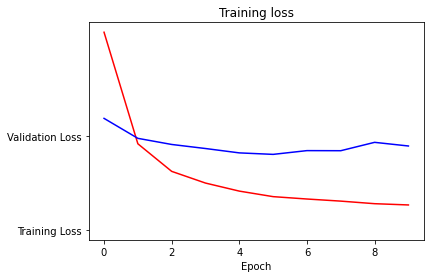

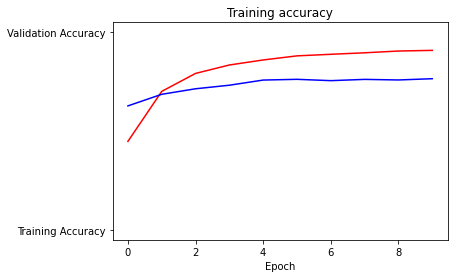

In [29]:
optimizer=Adam(learning_rate=0.001)
epochs=10
train_model(get_classificator_model(pretrained_model, last_output), optimizer, epochs, train_generator)

Epoch 1/30


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11732\1527297203.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


78/78 [==============================] - 147s 2s/step - loss: 2.2313 - accuracy: 0.4349 - val_loss: 1.2127 - val_accuracy: 0.6135
Epoch 2/30
78/78 [==============================] - 144s 2s/step - loss: 0.9794 - accuracy: 0.6762 - val_loss: 0.9399 - val_accuracy: 0.6990
Epoch 3/30
78/78 [==============================] - 145s 2s/step - loss: 0.7027 - accuracy: 0.7658 - val_loss: 0.8587 - val_accuracy: 0.7283
Epoch 4/30
78/78 [==============================] - 145s 2s/step - loss: 0.5696 - accuracy: 0.8072 - val_loss: 0.8268 - val_accuracy: 0.7413
Epoch 5/30
78/78 [==============================] - 145s 2s/step - loss: 0.4847 - accuracy: 0.8363 - val_loss: 0.8580 - val_accuracy: 0.7379
Epoch 6/30
78/78 [==============================] - 145s 2s/step - loss: 0.4256 - accuracy: 0.8550 - val_loss: 0.8291 - val_accuracy: 0.7488
Epoch 7/30
78/78 [==============================] - 145s 2s/step - loss: 0.3831 - accuracy: 0.8693 - val_loss: 0.8565 - val_accuracy: 0.7515
Epoch 8/30
78/78 [======

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11732\1527297203.py:21: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_accuracy = model.evaluate_generator(test_generator)[1]


Results at the end of training: accuracy=94.06%, test_accuracy=77.75%


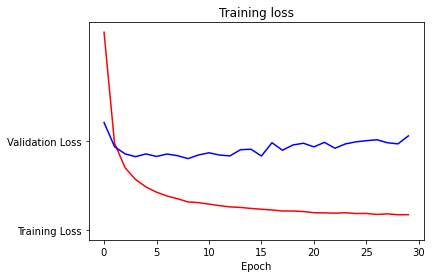

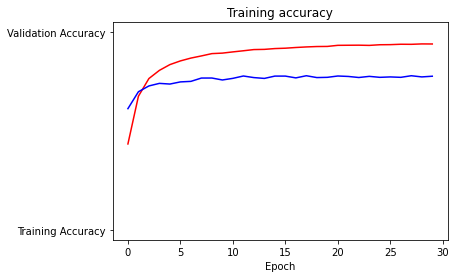

In [ ]:
optimizer=Adam(learning_rate=0.001)
epochs=30
train_model(get_classificator_model(pretrained_model, last_output), optimizer, epochs, train_generator)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10316\1527297203.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/50
78/78 [==============================] - 147s 2s/step - loss: 2.5799 - accuracy: 0.3933 - val_loss: 1.3321 - val_accuracy: 0.5937
Epoch 2/50
78/78 [==============================] - 149s 2s/step - loss: 1.0414 - accuracy: 0.6648 - val_loss: 0.9858 - val_accuracy: 0.6884
Epoch 3/50
78/78 [==============================] - 150s 2s/step - loss: 0.7187 - accuracy: 0.7635 - val_loss: 0.8777 - val_accuracy: 0.7262
Epoch 4/50
78/78 [==============================] - 156s 2s/step - loss: 0.5525 - accuracy: 0.8144 - val_loss: 0.8559 - val_accuracy: 0.7394
Epoch 5/50
78/78 [==============================] - 165s 2s/step - loss: 0.4585 - accuracy: 0.8440 - val_loss: 0.8523 - val_accuracy: 0.7431
Epoch 6/50
78/78 [==============================] - 157s 2s/step - loss: 0.3992 - accuracy: 0.8642 - val_loss: 0.7982 - val_accuracy: 0.7556
Epoch 7/50
78/78 [==============================] - 153s 2s/step - loss: 0.3566 - accuracy: 0.8776 - val_loss: 0.8381 - val_accuracy: 0.7605
Epoch 8/50
78

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10316\1527297203.py:21: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_accuracy = model.evaluate_generator(test_generator)[1]


Results at the end of training: accuracy=94.59%, test_accuracy=77.59%


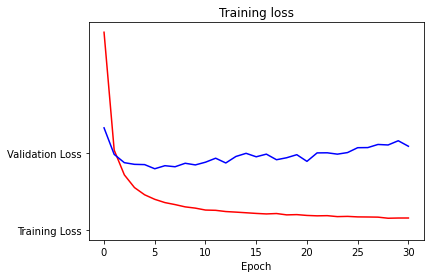

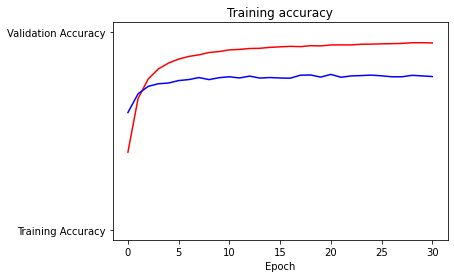

In [28]:
optimizer=Adam(learning_rate=0.001)
epochs=50
train_model(get_classificator_model(pretrained_model, last_output), optimizer, epochs, train_generator)